<a href="https://colab.research.google.com/github/bohuslavska/ai-house-fake-news-detection-homework/blob/master/Homework6.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [25]:
# ! python -m spacy download ru_core_news_lg
# ! pip install langdetect 
# ! pip install -U sentence-transformers
# ! pip install pyLDAvis
# ! pip install bertopic
# !pip install -U gensim

In [26]:
import os
import calendar

import pandas as pd
import numpy as np 
import nltk
nltk.download('stopwords')
nltk.download('punkt')
import spacy

import re
import string
from langdetect import detect as detect_lang

from matplotlib import pyplot as plt
import seaborn as sns

from nltk.corpus import stopwords
from nltk import tokenize
from wordcloud import WordCloud, STOPWORDS

from sentence_transformers import SentenceTransformer

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans, DBSCAN
from sklearn.metrics import pairwise_distances

from bertopic import BERTopic
import pyLDAvis
import pyLDAvis.gensim_models

from tqdm import tqdm

import gensim.corpora as corpora
import gensim

import ru_core_news_lg
nlp = ru_core_news_lg.load()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/usr/local/lib/python3.8/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.8/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.8/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/u

In [27]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Dataset Preprocessing


In [28]:
#I decided to work with a small part of the dataset because it makes computations much faster

df = pd.read_csv('/content/drive/MyDrive/Fake_news_detection/text_table.csv')
df = df.sample(frac = 0.05)

In [29]:
df.isna().sum() / df.shape[0]

Title       0.710582
Text        0.005875
Saved at    0.003713
Date        0.003713
Time        0.003713
dtype: float64

In [30]:
#Choosing samples without Nans

df = df[~df[["Text", "Saved at", "Date", "Time", "Title"]].isna().any(axis=1)].reset_index(drop=True)

In [31]:
#Removing duplicates from dataset

print(df.shape)
df.drop_duplicates(inplace=True)
print(df.shape)

(22297, 5)
(22297, 5)


In [32]:
def detect_lang_with_excep(input):
    try:
        return detect_lang(input)
    except:
        return "none"

In [33]:
#Choosing Russian samples

df["lang"] = df["Text"].apply(detect_lang_with_excep)
df["lang"].value_counts()

en      15977
ru       3365
de        991
fr        561
es        352
uk        323
no        140
af         91
bg         62
fi         58
id         46
ro         40
da         36
et         36
ca         33
lt         28
none       22
it         17
ml         14
pt         13
nl         12
sq         12
so         10
mk          9
sv          8
sl          6
fa          5
tr          4
ar          4
hr          4
cs          3
tl          3
gu          2
vi          2
sk          2
el          2
pl          2
hu          1
ja          1
Name: lang, dtype: int64

In [34]:
df = df[df["lang"] == "ru"].reset_index(drop=True)

In [35]:
print(df.shape)
df.to_csv('propaganda_dataset')

(3365, 6)


# Number of posts during different months

In [36]:
df["Date"] = pd.to_datetime(df["Date"])

In [37]:
#Number of posts during each month

df_month = pd.DataFrame(df.groupby("Date")["Text"].count())
data_monthly = df_month.resample('M').sum()
data_monthly

,Text
Date,
2022-03-31,238
2022-04-30,389
2022-05-31,330
2022-06-30,249
2022-07-31,264
2022-08-31,251
2022-09-30,265
2022-10-31,383
2022-11-30,323


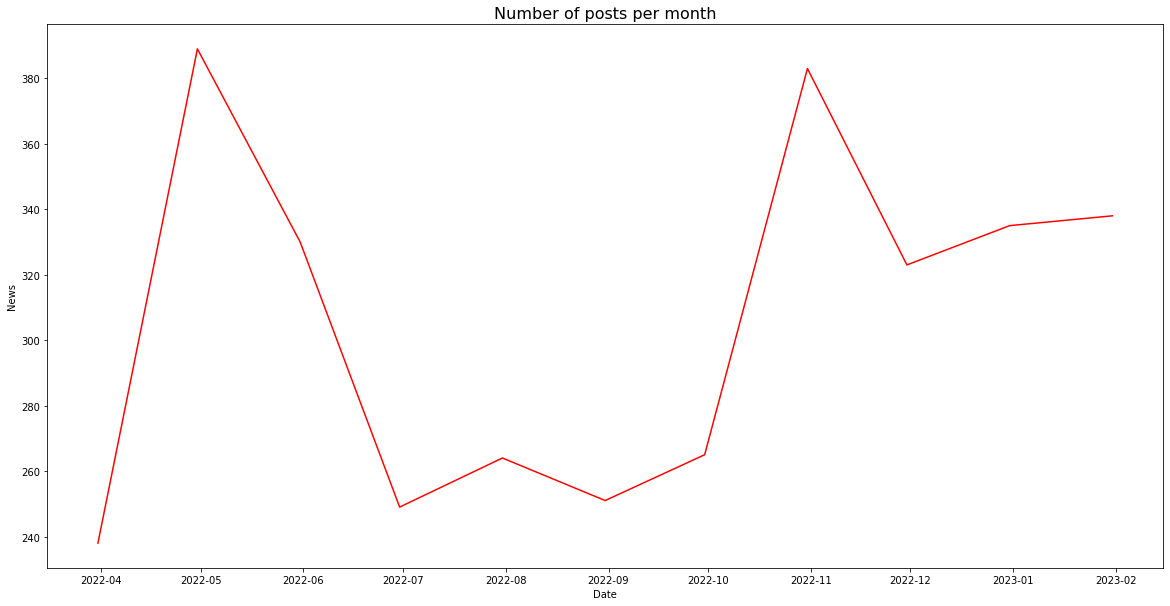

In [38]:
plt.figure(figsize=(20,10));
plt.ylabel('News');
plt.xlabel('Date');
plt.plot(data_monthly.index, data_monthly.values, color = 'red');
plt.title('Number of posts per month', fontsize=16);


# Number of posts in different days of week



In [39]:
df_weekday = pd.DataFrame(df['Text'].groupby(df['Date'].dt.weekday).count())
df_weekday.reset_index(inplace=True)
df_weekday['Date'] = df_weekday['Date'].apply(lambda x: calendar.day_name[x])
df_weekday

,Date,Text
0,Monday,522
1,Tuesday,529
2,Wednesday,566
3,Thursday,559
4,Friday,505
5,Saturday,332
6,Sunday,352


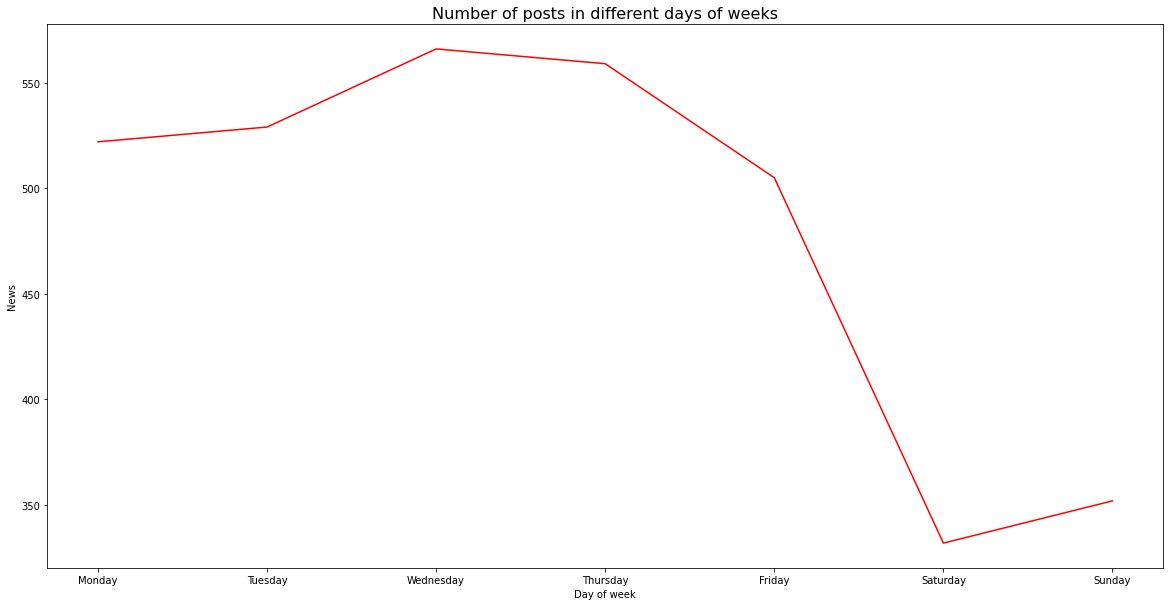

In [40]:
plt.figure(figsize=(20,10));
plt.ylabel('News');
plt.xlabel('Day of week');
plt.plot(df_weekday['Date'], df_weekday['Text'].values, color = 'red');
plt.title('Number of posts in different days of weeks', fontsize=16);

###Usually, people don't read the news at the weekends.

# Number of posts in different periods of the day

In [41]:
df['Time'] = pd.to_datetime(df['Time'], errors='coerce')
df['Time'].map(type).value_counts()

<class 'pandas._libs.tslibs.timestamps.Timestamp'>    3365
Name: Time, dtype: int64

In [42]:
df_timeday = pd.DataFrame(df['Text'].groupby(df['Time'].dt.hour).count())
df_timeday

,Text
Time,
0,26
1,14
2,18
3,25
4,51
5,99
6,195
7,249
8,234


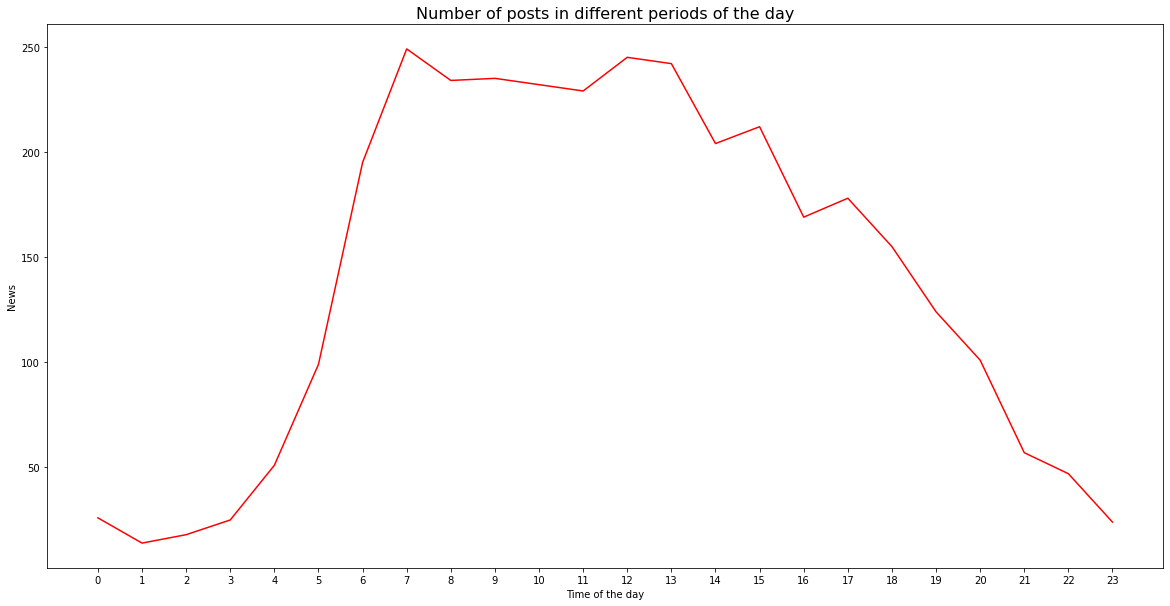

In [43]:
df_timeday.reset_index(inplace=True)

plt.figure(figsize=(20,10));
plt.ylabel('News');
plt.xlabel('Time of the day');
plt.xticks(np.arange(0, 24, step=1))
plt.plot(df_timeday['Time'], df_timeday['Text'].values, color = 'red');
plt.title('Number of posts in different periods of the day', fontsize=16);

###Quite expected that the biggest activity is between 7 a.m. and 5 p.m. when people don't sleep or rest.


#Clustering and dimensionality reduction


In [44]:
def remove_emojis(data):
    emoj = re.compile("["
        u"\U00002700-\U000027BF"  # Dingbats
        u"\U0001F600-\U0001F64F"  # Emoticons
        u"\U00002600-\U000026FF"  # Miscellaneous Symbols
        u"\U0001F300-\U0001F5FF"  # Miscellaneous Symbols And Pictographs
        u"\U0001F900-\U0001F9FF"  # Supplemental Symbols and Pictographs
        u"\U0001FA70-\U0001FAFF"  # Symbols and Pictographs Extended-A
        u"\U0001F680-\U0001F6FF"  # Transport and Map Symbols
                      "]+", re.UNICODE)
    return re.sub(emoj, '', data)

def light_preprocessing(text):
    text = remove_emojis(text)
    lower_text = [i.lower() for i in text]
    custom_punct = string.punctuation +"«" + "»‎"
    no_latin = [i for i in lower_text if i not in list(string.ascii_letters)]
    no_punct = [i for i in no_latin if i not in list(custom_punct)]
    no_punct = ''.join(no_punct)
    return no_punct

df['Preprocessed_light'] = df['Text'].apply(lambda x: light_preprocessing(x))
df

,Title,Text,Saved at,Date,Time,lang,Preprocessed_light
0,&#x26A1;&#xFE0F;Президент Гвинеи-Бисау Умару С...,❗️Президент Гвинеи-Бисау Умару Сисоку Эмбало н...,2022-10-26 20:44:57.100833200+00:00,2022-10-26,2023-03-06 19:09:50.000,ru,️президент гвинеибисау умару сисоку эмбало на ...
1,&#x26A1; Тверская область приняла вынужденных ...,Ilia Shevyakov Добрый день! Строительство трас...,2022-04-04 06:02:12.072191300+00:00,2022-04-04,2023-03-06 06:01:57.000,ru,добрый день строительство трассы м11 обход т...
2,&#x2757;&#xFE0F; Главное из нового брифинга Ми...,Брифинг официального представителя Министерств...,2022-05-07 08:09:28.420300600+00:00,2022-05-07,2023-03-06 08:08:11.000,ru,брифинг официального представителя министерств...
3,&#x1F914; Ещё одну взрывчатку нашли в Испании....,😳 Очередную посылку со взрывчаткой обнаружили ...,2022-12-01 13:53:10.477592100+00:00,2022-12-01,2023-03-06 13:30:19.000,ru,очередную посылку со взрывчаткой обнаружили в...
4,"Зеленский пообещал, что <b>Украина</b> не буде...","Напоминаем, что все комментарии, нарушающие пр...",2022-06-15 10:16:21.678370+00:00,2022-06-15,2023-03-06 07:25:03.997,ru,напоминаем что все комментарии нарушающие прав...
...,...,...,...,...,...,...,...
3360,Новороссия может стать реальностью,Новороссия может стать реальностью\n05/06/2022...,2022-05-06 13:17:55.340722400+00:00,2022-05-06,2023-03-06 13:14:01.000,ru,новороссия может стать реальностью\n05062022 1...
3361,"ООН: число беженцев в мире превысило 100 млн, ...","политического убежища за рубежом, а также 53 с...",2022-05-23 09:12:05.338662300+00:00,2022-05-23,2023-03-06 09:01:01.000,ru,политического убежища за рубежом а также 53 с ...
3362,&#x2757;&#xFE0F;Один из снарядов <b>украинской...,Новый брифинг Минобороны РФ. Главное:\n\n📍Попы...,2022-08-31 10:19:37.507875400+00:00,2022-08-31,2023-03-06 09:51:28.000,ru,новый брифинг минобороны рф главное\n\nпопытка...
3363,Сенат США одобрил $45 млрд помощи <b>Украине</...,Сенат США одобрил изъятие активов российских о...,2022-12-23 06:17:25.449833200+00:00,2022-12-23,2023-03-06 05:35:59.000,ru,сенат сша одобрил изъятие активов российских о...


In [47]:
emb_model = SentenceTransformer('DeepPavlov/rubert-base-cased', device = 'cpu')
news_embeddings = emb_model.encode(df["Preprocessed_light"].to_list(), show_progress_bar=True, batch_size=100)

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/34 [00:00<?, ?it/s]

##PCA

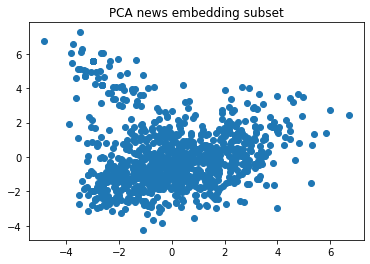

In [48]:
pca_news_embeddings_subset = PCA(random_state=42).fit_transform(news_embeddings[:1000])
plt.title("PCA news embedding subset")
plt.scatter(pca_news_embeddings_subset[:,0], pca_news_embeddings_subset[:,1])
plt.show()

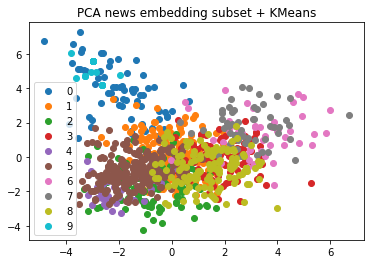

In [49]:
#PCA news embedding subset + KMeans

kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=10, 
    random_state=42, 
    init="k-means++"
).fit_predict(pca_news_embeddings_subset)

plt.title("PCA news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        pca_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        pca_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

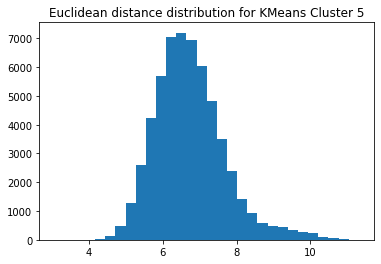

In [50]:
estimated_dists = pairwise_distances(
    pca_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == 5]
).flatten()

plt.title("Euclidean distance distribution for KMeans Cluster 5")
plt.hist(estimated_dists[estimated_dists != 0], bins=30)
plt.show()

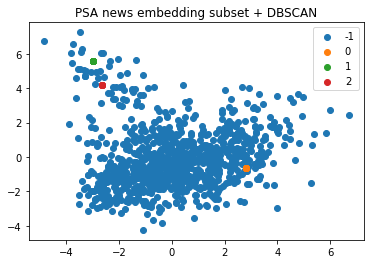

In [51]:
#PCA news embedding subset + DBSCAN

dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=4,
    min_samples=5
).fit_predict(pca_news_embeddings_subset)

plt.title("PSA news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        pca_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        pca_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

###Have no idea why PSA shows such a strange result. 

#TSNE

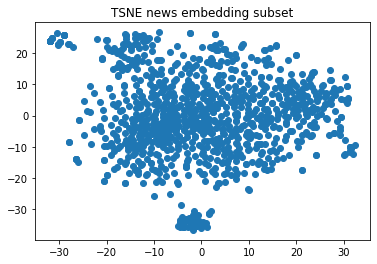

In [52]:
tsne_news_embeddings_subset = TSNE(random_state=42).fit_transform(news_embeddings[:1000])
plt.title("TSNE news embedding subset")
plt.scatter(tsne_news_embeddings_subset[:,0], tsne_news_embeddings_subset[:,1])
plt.show()

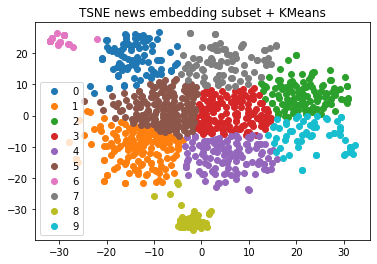

In [53]:
#TSNE news embedding subset + KMeans

kmeans_clusts_news_embeddings_subset = KMeans(
    n_clusters=10, 
    random_state=42, 
    init="k-means++"
).fit_predict(tsne_news_embeddings_subset)

plt.title("TSNE news embedding subset + KMeans")
for clust in np.unique(kmeans_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

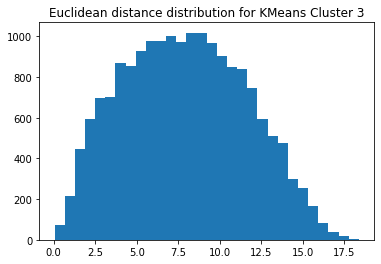

In [54]:
estimated_dists = pairwise_distances(
    tsne_news_embeddings_subset[kmeans_clusts_news_embeddings_subset == 3]
).flatten()

plt.title("Euclidean distance distribution for KMeans Cluster 3")
plt.hist(estimated_dists[estimated_dists != 0], bins=30)
plt.show()

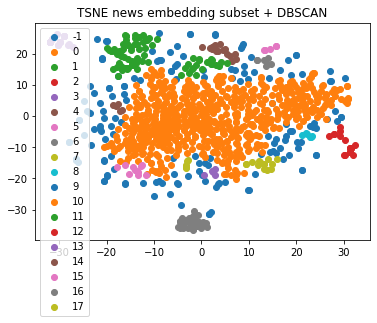

In [87]:
#TSNE news embedding subset + DBSCAN

dbscan_clusts_news_embeddings_subset = DBSCAN(
    eps=2,
    min_samples=5
).fit_predict(tsne_news_embeddings_subset)

plt.title("TSNE news embedding subset + DBSCAN")
for clust in np.unique(dbscan_clusts_news_embeddings_subset):
    plt.scatter(
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 0],
        tsne_news_embeddings_subset[dbscan_clusts_news_embeddings_subset == clust, 1],
        label=str(clust)
    )
plt.legend()
plt.show()

###At least better than PSA.

#LDA

###I decided to use exhaustive preprocessing for both LDA and BERTopic. Because LDA without lemmatization perceives "украине" and "украину" as different words. BERTopic shows that words such as "это" are main topics. I know that usually transformers don't need a lot of data preprocessing but I hope here it will work.

In [56]:
df = pd.read_csv('/content/propaganda_dataset')
df.shape

(3365, 7)

In [57]:
nlp = spacy.load('ru_core_news_lg')

def text_preprocessing(text):
    text = remove_emojis(text)
    russian_stop_words = stopwords.words('russian')
    lower_text = [i.lower() for i in text]
    custom_punct = string.punctuation +"«" + "»‎"
    no_latin = [i for i in lower_text if i not in list(string.ascii_letters)]
    no_digits = [i for i in no_latin if i not in list(string.digits)]
    no_punct = [i for i in no_digits if i not in list(custom_punct)]
    no_punct = ''.join(no_punct)
    no_sw = [i for i in no_punct.split() if i not in russian_stop_words]
    no_sw = ' '.join(no_sw)
    document = nlp(no_sw)
    result = " ".join([token.lemma_ for token in document])
    return result

/usr/local/lib/python3.8/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.8/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.8/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.getargspec(cls.__init__)
/usr/local/lib/python3.8/dist-packages/pymorphy2/units/base.py:70: DeprecationWarning: inspect.getargspec() is deprecated since Python 3.0, use inspect.signature() or inspect.getfullargspec()
  args, varargs, kw, default = inspect.g

In [58]:
df['Preprocessed'] = df['Text'].apply(lambda x: text_preprocessing(x))

In [59]:
docs = []
for d in tqdm(df["Preprocessed"].to_list()):
    docs.append(
        [el for el in tokenize.word_tokenize(d)]
    )

100%|██████████| 3365/3365 [00:00<00:00, 3505.17it/s]


In [60]:
vocab = corpora.Dictionary(docs)
corpus = [vocab.doc2bow(text) for text in docs]
print(
    f"Text:\n{' '.join(docs[0])}\n\n"
    f"Text BOW:\n{corpus[0]}"
)

Text:
️президент гвинеибисау умар сисоку эмбало прессконференции лидер киевский режим владимир зеленским киеве заявить время визит москва президент россия владимир путин просить передать зеленскому устный послание вчера россия президент путин просить передать месседж поговорить вами — рассказать эмбало слово послание заключаться переговоры необходимый президент гвинеибисау подчеркнуть диалог особенность нужный продолжение поставка продовольствие африка

Text BOW:
[(0, 1), (1, 1), (2, 1), (3, 2), (4, 1), (5, 1), (6, 2), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 2), (22, 1), (23, 1), (24, 2), (25, 1), (26, 3), (27, 1), (28, 1), (29, 1), (30, 2), (31, 2), (32, 1), (33, 1), (34, 2), (35, 1), (36, 1), (37, 1), (38, 1), (39, 2), (40, 1), (41, 1)]


In [61]:
num_topics = 10
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=vocab,
                                       num_topics=num_topics)
print(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0, '0.018*"украина" + 0.010*"российский" + 0.006*"—" + 0.006*"россия" + 0.005*"новый" + 0.005*"это" + 0.005*"иностранный" + 0.004*"год" + 0.004*"война" + 0.004*"обстрел"'), (1, '0.022*"украина" + 0.013*"—" + 0.009*"россия" + 0.008*"военный" + 0.006*"область" + 0.005*"рф" + 0.004*"российский" + 0.004*"🇺" + 0.004*"человек" + 0.004*"🇦"'), (2, '0.025*"украина" + 0.013*"россия" + 0.006*"—" + 0.006*"российский" + 0.005*"год" + 0.005*"война" + 0.004*"иностранный" + 0.004*"заявить" + 0.004*"военный" + 0.004*"киев"'), (3, '0.019*"украина" + 0.007*"военный" + 0.006*"—" + 0.006*"заявить" + 0.005*"россия" + 0.005*"область" + 0.004*"🇦" + 0.004*"российский" + 0.004*"год" + 0.004*"🇺"'), (4, '0.015*"украина" + 0.010*"—" + 0.009*"россия" + 0.007*"рф" + 0.005*"российский" + 0.005*"подписаться" + 0.005*"это" + 0.005*"область" + 0.004*"заявить" + 0.004*"–"'), (5, '0.020*"украина" + 0.014*"россия" + 0.009*"—" + 0.007*"президент" + 0.007*"российский" + 0.007*"рф" + 0.006*"область" + 0.006*"владимир" + 0.0

In [62]:
pyLDAvis.enable_notebook()
LDAvis_prepared = pyLDAvis.gensim_models.prepare(lda_model, corpus, vocab)
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.001050  0.002433       1        1  14.852278
2      0.019488 -0.038474       2        1  12.856077
6      0.002242  0.034616       3        1  11.116946
3      0.016188 -0.044416       4        1  10.182701
0      0.011995  0.013636       5        1   9.917181
1     -0.034169  0.023079       6        1   9.874579
7     -0.006910  0.044073       7        1   9.640892
4     -0.083954 -0.039133       8        1   7.455109
8      0.052640 -0.033862       9        1   7.067125
9      0.021431  0.038047      10        1   7.037111, topic_info=             Term        Freq       Total Category  logprob  loglift
138   иностранный  237.000000  237.000000  Default  30.0000  30.0000
454       функция  113.000000  113.000000  Default  29.0000  29.0000
424         агент  115.000000  115.000000  Default  28.0000  28.0000
3020           ул   88.000000   88.000000  Default  27.0000  27.0000
426     выполнять  123.000000  123.000000  Default  26.0000  26.0000
...           ...         ...         ...      ...      ...      ...
34         россия   30.773029  905.093407  Topic10  -5.5047  -0.7274
675         также   20.255985  325.843553  Topic10  -5.9229  -0.1240
9         заявить   19.485385  411.535080  Topic10  -5.9616  -0.3963
304       обстрел   16.885666  217.021456  Topic10  -6.1048   0.1004
390           это   17.494067  372.668849  Topic10  -6.0694  -0.4049

[897 rows x 6 columns], token_table=       Topic      Freq       Term
term                             
3574       3  0.114626  абрамович
3574       4  0.114626  абрамович
3574       5  0.687759  абрамович
3574       7  0.114626  абрамович
14912      5  0.837467  авторитет
...      ...       ...        ...
253        6  0.164104          🇺
253        7  0.078322          🇺
253        8  0.063404          🇺
253        9  0.059674          🇺
253       10  0.059674          🇺

[2554 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 3, 7, 4, 1, 2, 8, 5, 9, 10])

#BERTopic

In [63]:
topic_model = BERTopic(embedding_model="DeepPavlov/rubert-base-cased", verbose=True)
topics, probs = topic_model.fit_transform(df['Preprocessed'].to_list())

Some weights of the model checkpoint at /root/.cache/torch/sentence_transformers/DeepPavlov_rubert-base-cased were not used when initializing BertModel: ['cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Batches:   0%|          | 0/106 [00:00<?, ?it/s]

2023-03-06 19:49:09,453 - BERTopic - Transformed documents to Embeddings
2023-03-06 19:49:53,591 - BERTopic - Reduced dimensionality
2023-03-06 19:49:53,783 - BERTopic - Clustered reduced embeddings


In [64]:
topic_model.get_topic_info()

,Topic,Count,Name
0,0,3018,0_украина_россия_российский_военный
1,1,172,1_спасибо_тревога_украина_андрей
2,2,59,2_правило_нарушать_напоминать_удалить
3,3,44,3_россия_украина_это_военный
4,4,37,4_брифинг_игорь_конашенкова_минобороны
5,5,21,5_ва_россия_бу_украина
6,6,14,6_нецензурный_транслитом_заглавный_лексика


In [65]:
topic_model.get_topic(2)

[('правило', 0.5283489939436881),
 ('нарушать', 0.46912629890903446),
 ('напоминать', 0.42797361823112284),
 ('удалить', 0.424981340006622),
 ('комментарий', 0.4106620030886176),
 ('комментирование', 0.4097857260427975),
 ('соблюдать', 0.3859611498604147),
 ('заблокировать', 0.3801540698055969),
 ('пользователь', 0.370426447544422),
 ('группа', 0.3597169250851841)]

In [66]:
topic_model.visualize_topics()

###BERTopic with "DeepPavlov" behaves in a strange way. Let's try different embedding model.

In [67]:
# TODO: Try different models and hyperparameters. Link https://github.com/MaartenGr/BERTopic 

topic_model = BERTopic(embedding_model="distiluse-base-multilingual-cased-v1", verbose=True)
topics, probs = topic_model.fit_transform(df['Preprocessed'].to_list())

Batches:   0%|          | 0/106 [00:00<?, ?it/s]

2023-03-06 19:59:11,203 - BERTopic - Transformed documents to Embeddings
2023-03-06 19:59:40,473 - BERTopic - Reduced dimensionality
2023-03-06 19:59:40,652 - BERTopic - Clustered reduced embeddings


In [68]:
topic_model.get_topic_info()

,Topic,Count,Name
0,-1,1432,-1_украина_россия_российский_военный
1,0,167,0_ракета_всу_российский_военный
2,1,134,1_убийство_видео_дело_преступление
3,2,117,2_зеленский_зеленского_президент_владимир
4,3,104,3_андрей_дмитрий_вечный_писать
5,4,103,4_погибнуть_человек_обстрел_дом
6,5,102,5_ул_добрый_ремонт_работа
7,6,95,6_взрыв_область_пво_ова
8,7,62,7_электроэнергия_аэс_отключение_энергосистема
9,8,55,8_иностранный_функция_агент_выполнять


In [82]:
topic_model.get_topic(2)

[('зеленский', 0.06394291243728767),
 ('зеленского', 0.047640153914313185),
 ('президент', 0.04416661106115234),
 ('владимир', 0.04356340762530699),
 ('украина', 0.0219539441414334),
 ('сша', 0.018275888020700955),
 ('визит', 0.015154673212060332),
 ('россия', 0.013921022666931284),
 ('зеленским', 0.012842757487416746),
 ('офис', 0.012607752387685618)]

In [70]:
topic_model.visualize_topics()

###"Distiluse-base-multilingual-cased-v1" model shows much better result.

# Popularity check

### Both in LDA and BERTopic we can notice such topics as "украина", "россия", "сша", "война", "зеленский". It is clear why "россия" is mentioned a lot in russian news. Let's check the popularity of the other topics depending on the Date. 

###Ukraine

In [71]:
df["Date"] = pd.to_datetime(df["Date"])

In [72]:
#Function for popularity check

def popularity_check (topic): 
     news = df[['Preprocessed', 'Date']].loc[df['Preprocessed'].str.contains(topic)]
     df_month = pd.DataFrame(news.groupby("Date")["Preprocessed"].count())
     data_monthly = df_month.resample('M').sum()
     percentage = news.shape[0]*100/ df[['Preprocessed', 'Date']].shape[0]
     return round(percentage, 2), data_monthly

In [73]:
#Function for the visual representation of the popularity

def popularity_visual(data, title):
  plt.figure(figsize=(20,10));
  plt.ylabel('News');
  plt.xlabel('Date');
  plt.plot(data.index, data.values, color = 'red');
  plt.title(title, fontsize=16);

In [74]:
topic = 'украин'
percentage, data_ukr = popularity_check('украин')
print(f'{percentage}% of the whole dataset')

69.93% of the whole dataset


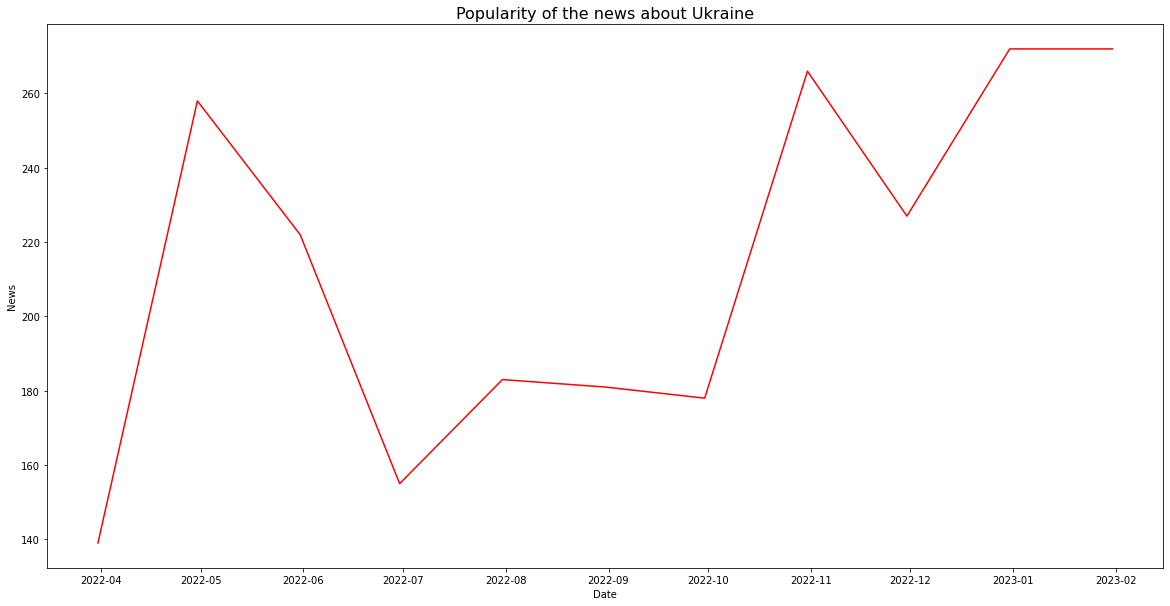

In [75]:
title = 'Popularity of the news about Ukraine'
data = data_ukr
popularity_visual(data, title)

###I guess that the surge in November is caused by the liberation of Kherson:)

###USA

In [76]:
topic = 'сша'
percentage, data_usa = popularity_check('сша')
print(f'{percentage}% of the whole dataset')

5.26% of the whole dataset


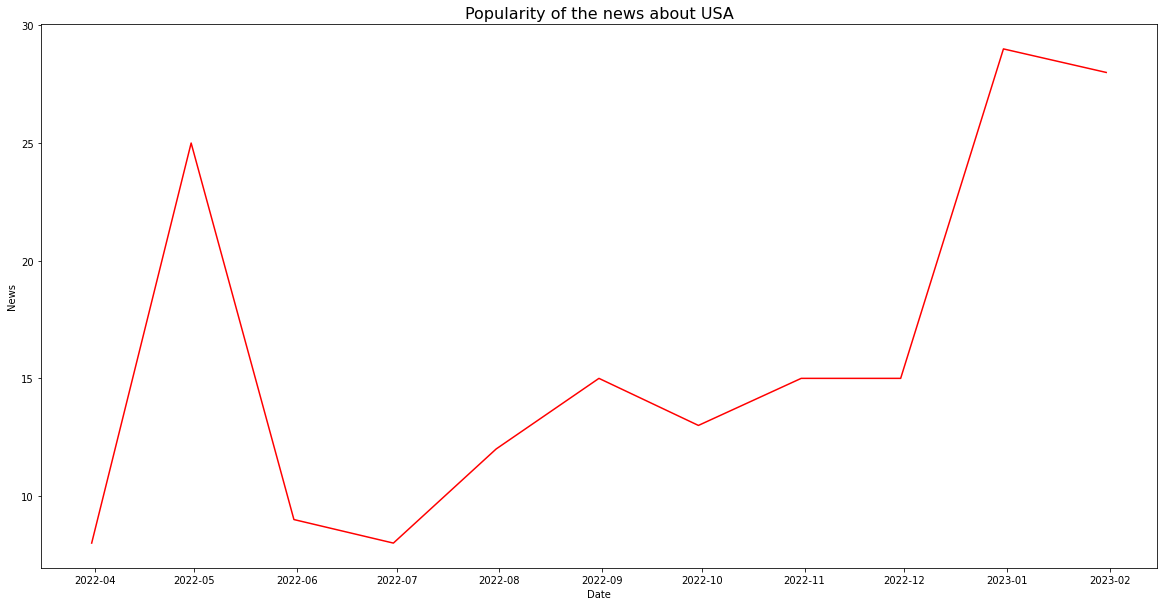

In [77]:
title = 'Popularity of the news about USA'
data = data_usa
popularity_visual(data, title)

###Maybe the surge of activity is caused by the stepping up of the weapons supply.

###War

In [78]:
topic = 'война'
percentage, data_war = popularity_check(topic)
print(f'{percentage}% of the whole dataset')

8.56% of the whole dataset


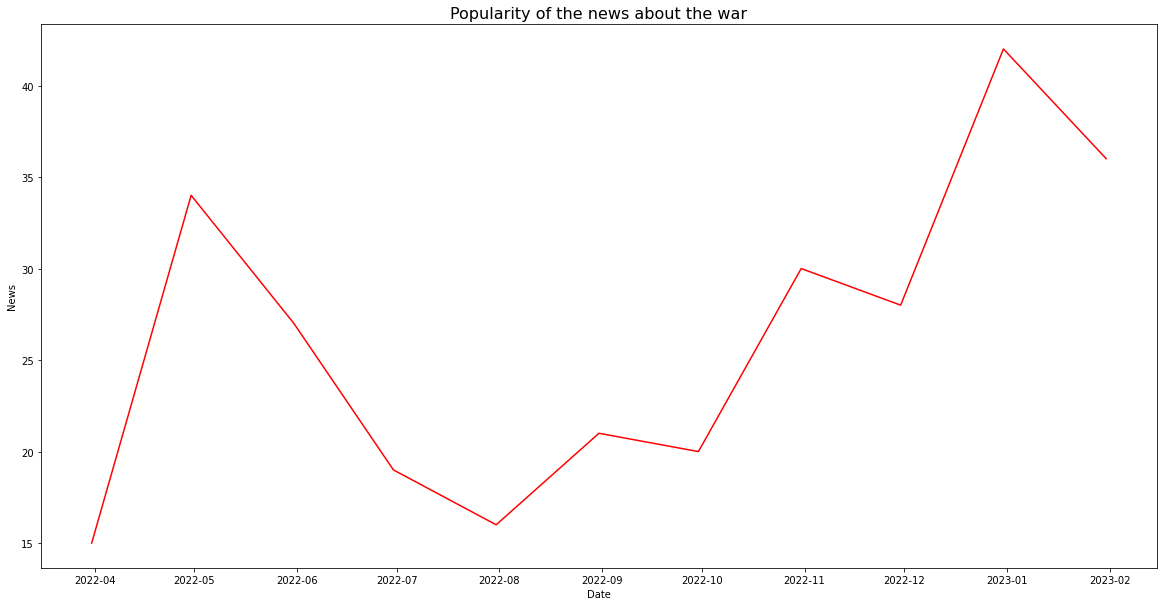

In [79]:
title = 'Popularity of the news about the war'
data = data_war
popularity_visual(data, title)

###Zelenskyy

In [83]:
topic = 'зеленск'
percentage, data_president = popularity_check(topic)
print(f'{percentage}% of the whole dataset')

4.87% of the whole dataset


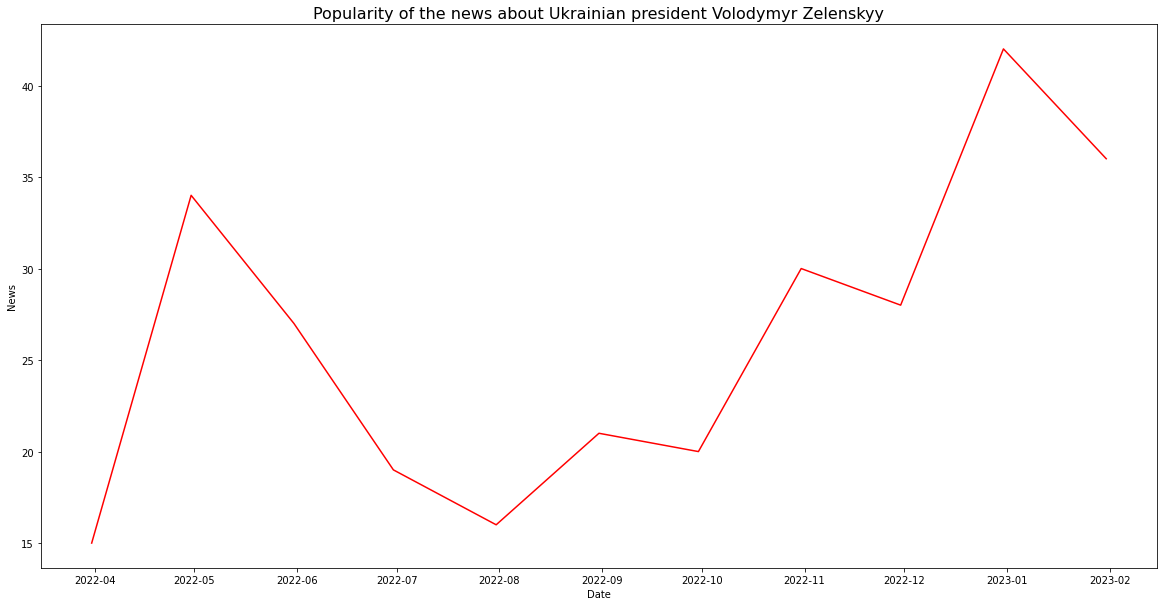

In [84]:
title = 'Popularity of the news about Ukrainian president Volodymyr Zelenskyy'
data = data_war
popularity_visual(data, title)